In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [26]:
year=2019
quarter=3

algorithm="a_star"
moneyMultiplier=0

In [27]:
dropColumns=["tbl","citymarketid_1","citymarketid_2","airportid_1","airportid_2","tbl1apk"]
data=pd.read_csv('../US Airline Flight Routes and Fares 1993-2024.csv').drop(columns=dropColumns).dropna().reset_index(drop=True)
data=data.loc[(data["city1"]!="Key West, FL") & (data["city2"]!="Key West, FL") & (data["city1"]!="Tulsa, OK") & (data["city2"]!="Tulsa, OK"),:].reset_index(drop=True)
# data=data.loc[(data["Year"]==year) & (data["quarter"]==quarter),:].reset_index(drop=True)
len(data)

C:\Users\alt_user\AppData\Local\Temp\ipykernel_12416\4253822912.py:2: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('../US Airline Flight Routes and Fares 1993-2024.csv').drop(columns=dropColumns).dropna().reset_index(drop=True)


202867

In [28]:
data=data.sample(3000, random_state=42)

In [29]:
G = nx.MultiDiGraph()

dataNp=data["city1"].to_numpy()
posNp=data["Geocoded_City1"].to_numpy()
for airport, pos in zip(dataNp,posNp):
    pos=pos.split("(")[-1][:-1]
    latitude,longtitude=pos.split(",")
    pos=(float(latitude),float(longtitude))
    G.add_node(airport,pos=pos)


dataNp=data["city2"].to_numpy()
posNp=data["Geocoded_City2"].to_numpy()
for airport, pos in zip(dataNp,posNp):
    pos=pos.split("(")[-1][:-1]
    latitude,longtitude=pos.split(",")
    pos=(float(latitude),float(longtitude))
    G.add_node(airport,pos=pos)

In [30]:
import heapq
from math import radians, sin, cos, sqrt, asin

def a_star(graph, start, goal, h):
    dist = {node: float('inf') for node in graph}
    dist[start] = 0

    prev = {node: None for node in graph}

    # Priority queue stores (f_score, node), where f_score = dist[node] + h(node, goal)
    pq = [(dist[start] + h(start, goal), start)]
    previousVisits = set()
    # previousVisits.add(start)
    while pq:
        # print("pq: ", pq)
        f_score, current_node = heapq.heappop(pq)
        # print("yes")
        if(current_node in previousVisits):
            continue
        # If we've reached the goal, we can stop
        if current_node == goal:
            break

        # If the f_score is out of date, skip
        if f_score > dist[current_node] + h(current_node, goal):
            continue

        # For each neighbor, check if we have found a better path
        previousVisits.add(current_node)
        # print(graph_neighbors)
        for _, neighbor, key in graph.out_edges(current_node, keys=True):
            edge=graph.edges[(current_node, neighbor, key)]
            price=edge["price"]
            weight = edge["weight"] + moneyMultiplier * price
            tentative_g_score = dist[current_node] + weight


            if tentative_g_score < dist[neighbor]:
                dist[neighbor] = tentative_g_score
                prev[neighbor] = current_node
                # Recompute f-score = g-score + heuristic
                heapq.heappush(pq, (dist[neighbor] + h(neighbor, goal), neighbor))

    return dist, prev

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

def heuristic(u, v):
    lat1, lon1 = G.nodes[u]['pos']
    lat2, lon2 = G.nodes[v]['pos']
    distance=haversine(lat1,lon1,lat2,lon2)
    return distance



def dijkstra(graph, start):
    dist = {node: float('inf') for node in graph}
    dist[start] = 0

    # Keep track of the path
    prev = {node: None for node in graph}
    pq = [(0, start)]

    while pq:
        current_dist, current_node = heapq.heappop(pq)

        # If this distance is outdated (i.e., we already found a better path), skip
        if current_dist > dist[current_node]:
            continue
        
        #Dijkstra’s doesn't need a goal parameter because it calculates the shortest path to all nodes

        # Explore neighbors
        for _, neighbor, key in graph.out_edges(current_node, keys=True):
            edge=graph.edges[(current_node, neighbor, key)]

            weight = edge["weight"] + moneyMultiplier * edge["price"]
            new_dist = dist[current_node] + weight
            if new_dist < dist[neighbor]:
                dist[neighbor] = new_dist
                prev[neighbor] = current_node
                heapq.heappush(pq, (new_dist, neighbor))

    return dist, prev


import heapq

def is_dominated(new_vec, existing_vecs):
    """Check if new_vec is dominated by any vector in existing_vecs."""
    for vec in existing_vecs:
        if (vec[0] <= new_vec[0] and vec[1] <= new_vec[1]):
            return True
    return False

def reconstruct_path(start, goal, pareto_front, predecessors):
    """Trace back from goal to start for each Pareto-optimal cost vector."""
    paths = []
    for (total_dist, total_money) in pareto_front:
        path = []
        current_node = goal
        current_cost = (total_dist, total_money)
        
        # Backtrack from goal to start
        while current_node is not None:
            path.append(current_node)
            pred_info = predecessors[current_node].get(current_cost, None)
            
            if pred_info is None:
                break  # Reached the start node
            
            # Move to predecessor and update current cost
            prev_node, prev_dist, prev_money = pred_info
            current_node = prev_node
            current_cost = (prev_dist, prev_money)
        
        # Reverse to get path from start to goal
        path.reverse()
        if path[0] == start:
            paths.append((path, (total_dist, total_money)))
    
    return paths

def multi_criteria_a_star(graph, start, goal, h):
    # Track non-dominated (distance, money) vectors for each node
    cost_map = {node: [] for node in graph}
    cost_map[start] = [(0, 0)]  # (distance, money)

    # Predecessor map: {node: {(distance, money): (prev_node, prev_distance, prev_money)}}
    prev = {node: {} for node in graph}
    prev[start][(0, 0)] = None

    # Priority queue: (f_distance, node, current_distance, current_money)
    pq = []
    h_start = h(start, goal)
    
    heapq.heappush(pq, (0 + h_start, start, 0, 0))

    while pq:
        f_dist, current, curr_dist, curr_money = heapq.heappop(pq)

        # Skip if this cost vector is no longer in cost_map (dominated)
        if (curr_dist, curr_money) not in cost_map[current]:
            continue

        # Early exit if we reach the goal (but continue to find all Pareto-optimal paths)
        if current == goal:
            # print("Reached goal with cost: ", (curr_dist, curr_money))
            continue  # Or break if you want first solution

        # Explore neighbors
        for _, neighbor, key in graph.out_edges(current, keys=True):
            edge_data = graph.edges[(current, neighbor, key)]
            new_dist = curr_dist + edge_data["weight"]
            new_money = curr_money + edge_data["price"]

            # Check if this new vector is dominated by existing ones
            new_vec = (new_dist, new_money)
            if is_dominated(new_vec, cost_map[neighbor]):
                # if neighbor==goal:
                #     print("Dominated vector: ", new_vec, " for neighbor: ", neighbor)
                #     print("Existing vectors: ", cost_map[neighbor])
                #     print("---------------")
                continue

            # Add to cost_map and update predecessors
            cost_map[neighbor] = [vec for vec in cost_map[neighbor] if not (new_vec[0] <= vec[0] and new_vec[1] <= vec[1])]
            cost_map[neighbor].append(new_vec)
            prev[neighbor][new_vec] = (current, curr_dist, curr_money)

            # Calculate heuristic for neighbor
            h_neighbor = h(neighbor, goal)
            f_dist_new = new_dist + h_neighbor

            heapq.heappush(pq, (f_dist_new, neighbor, new_dist, new_money))

    # Extract Pareto-optimal paths to goal
    pareto_front = cost_map.get(goal, [])
    return pareto_front, prev

In [31]:
flights=[]

dfNp=data.to_numpy()

for flight in dfNp:
    origin, dest, distance, fare, originPos, destPos = flight[2], flight[3], flight[6], flight[8], flight[-2], flight[-1]
    flights.append((origin,dest,distance,fare,originPos,destPos))
    G.add_edge(origin,dest,weight=distance,price=fare)

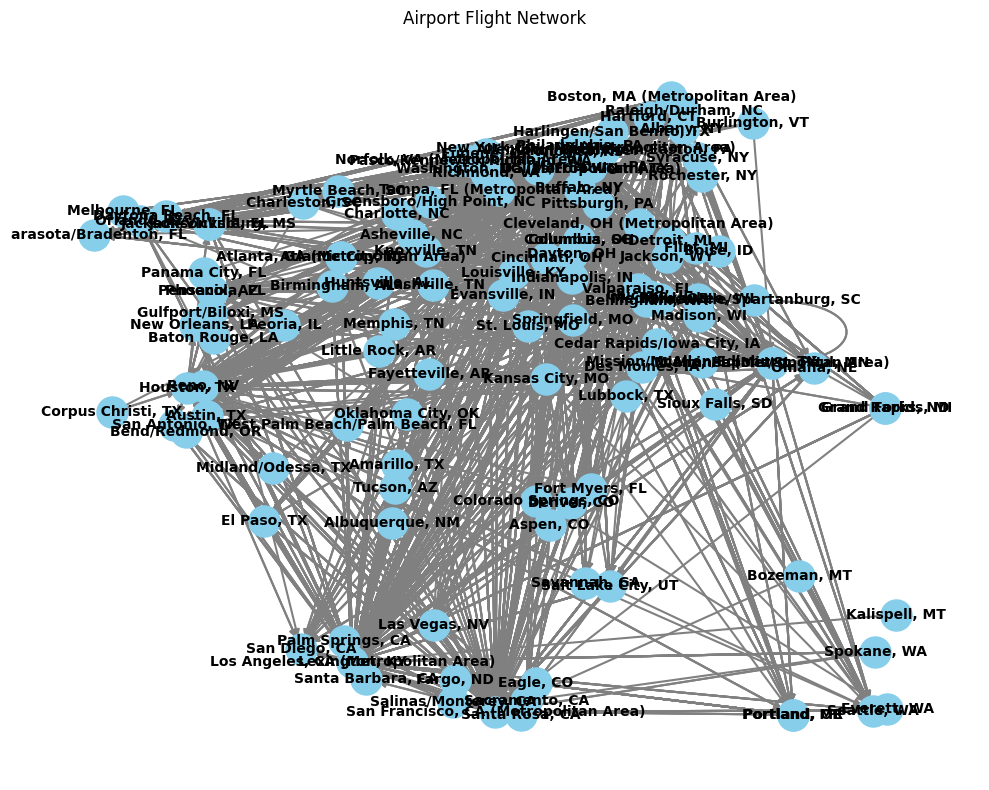

In [32]:
plt.figure(figsize=(10, 8)),
# pos = nx.spring_layout(G, seed=42)
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")
nx.draw_networkx_edges(G, pos, width=1.5, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Add edge labels (distance)
edge_labels = nx.get_edge_attributes(G, "distance")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

plt.title("Airport Flight Network")
plt.axis("off")
# plt.show()
plt.tight_layout(); 

In [21]:

if(input("Do you want random start and end cities? (y/n) ")=="y"):
    start= data.sample(1)["city1"].values[0]
    end= data.sample(1)["city2"].values[0]

else:
    start = 'Atlanta, GA (Metropolitan Area)'
    end = 'Eugene, OR'
print("Start: ",start," End: ",end)

# start = 'Los Angeles, CA (Metropolitan Area)'
# end = 'Reno, NV'
# Start:  Los Angeles, CA (Metropolitan Area)  End:  Seattle, WA

Start:  Des Moines, IA  End:  Phoenix, AZ


In [22]:
import time
start_time = time.time()

print("Dijkstra") 
distances, preds = dijkstra(G, start)
if(distances[end]==float('inf')):
    print("No path found")
else:
    path = []
    node = end
    while node is not None:
        path.append(node)
        node = preds[node]
    path.reverse()
    print(f"Optimal Flight Path: {path}, Distance with heuristic: {distances[end]} km")
print("--- %s seconds Dijkstra's---" % (time.time() - start_time))

start_time = time.time()

# #####################
print("A*")
distances, preds = a_star(G, start, end, heuristic)

path = []
node = end
while node is not None:
    path.append(node)
    node = preds[node]
path.reverse()
# path = nx.astar_path(G, start, end, heuristic=heuristic, weight='weight')
print(f"Optimal Flight Path: {path}, Distance with heuristic: {distances[end]} km")
print("--- %s seconds A*---" % (time.time() - start_time))

Dijkstra
Optimal Flight Path: ['Des Moines, IA', 'Phoenix, AZ'], Distance with heuristic: 1150.0 km
--- 0.001999378204345703 seconds Dijkstra's---
A*
Optimal Flight Path: ['Des Moines, IA', 'Phoenix, AZ'], Distance with heuristic: 1150.0 km
--- 0.0 seconds A*---


In [23]:
print("Multi A*")
start_time = time.time()
pareto_front, predecessors = multi_criteria_a_star(G, start, end, heuristic)
paths = reconstruct_path(start, end, pareto_front, predecessors)

# Print results
for path, (distance, money) in paths:
    print(f"Path: {path}, Distance: {distance}, Money: {money}")
print("--- %s seconds A*---" % (time.time() - start_time))

Multi A*
Path: ['Des Moines, IA', 'Phoenix, AZ'], Distance: 1150, Money: 128.97
--- 0.0020012855529785156 seconds A*---


In [24]:
# nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10)

# # Highlight the optimal path
# path_edges = list(zip(path, path[1:]))
# nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3)

# plt.title("Optimal Flight Path Using A*")
# plt.show(); 